# Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import opendatasets as od
import os
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard


In [2]:
writer = SummaryWriter('runs/gan_experiment-2')


# Dataset  

In [10]:
DATA_DIR = os.path.join(os.getcwd(), "CelebAzip\img_align_celeba")

def bgr_to_rgb(image):
    return image[[2, 1, 0], :, :]
stats = ((0.5063, 0.4258, 0.3832),(0.2657, 0.2452, 0.2414))
DATA_DIR
train_ds  = ImageFolder(DATA_DIR, transform=transforms.Compose(
    [transforms.Resize(64),
     transforms.CenterCrop(64),
     transforms.ToTensor(),
     transforms.Lambda(bgr_to_rgb),  # Apply BGR to RGB conversion
     transforms.Normalize(*stats)]
))

# Data loader

In [11]:
batch_size = 256

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3
, pin_memory=True)


# CUDA

In [13]:
def to_device(data ,device):
  if isinstance(data , (list , tuple)):
    return [to_device(x ,device) for x in data]
  return data.to(device , non_blocking=True)

class DeviceDataLoader():

  def __init__(self, dl ,device):
    self.dl  = dl
    self.device  =  device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b ,self.device)

  def __len__(self):
    return len(self.dl)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
train_dl_cuda = DeviceDataLoader(train_dl , device)

train_dl_cuda.device

device(type='cuda')

# VISUALISATION

In [15]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

def show_images(images , nmax=16):
  fig,ax = plt.subplots(figsize = (16,16))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=16).permute(1,2,0))
  plt.show()

def show_batch(dl):
  for images , _ in dl:
    show_images(images )
    break



In [16]:

show_batch(train_dl_cuda)

# DISCRIMINATOR

In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)



GENERATOR

In [34]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [35]:

latent_size = 256
generator = Generator(latent_size).to(device)
discriminator = Discriminator().to(device)


torch.Size([400, 3, 256, 256]) torch.Size([400, 256, 1, 1])


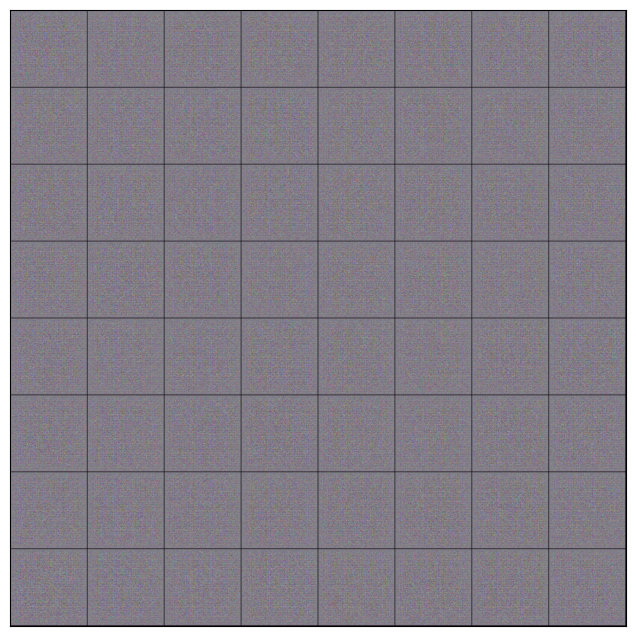

In [36]:
xb  = torch.randn(batch_size , latent_size ,1,1)

fake_images = generator(xb.to(device))
print(fake_images.shape,xb.shape)
show_images(fake_images)

# Train Discriminator

In [37]:

def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    batch_size = real_images.size(0)  # Get batch size from real_images

    real_preds = discriminator(real_images)
    real_targets = torch.ones(batch_size, 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(batch_size, 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


# Train Generator

In [38]:
def train_genrator(opt_g):

    opt_g.zero_grad()

    latent = torch.randn(batch_size , latent_size ,1,1).to(device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.ones(batch_size , 1 , device=device)
    loss = F.binary_cross_entropy(fake_preds , fake_targets)

    loss.backward()
    opt_g.step()

    return  loss.item()


# Save batch of Images


In [39]:
save_image_dir = "generated-3"
os.makedirs(save_image_dir, exist_ok=True)

In [40]:
def save_generated_image(index  , latent_tensors , show=True):
  fake_images = generator(latent_tensors)
  fake_fname = "generated-images-{0:0=4d}.png".format(index)
  save_image(denorm(fake_images), os.path.join(save_image_dir, fake_fname), nrow=20)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=20).permute(1, 2, 0))
    plt.show()

In [41]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [42]:
save_generated_image(0, fixed_latent)

In [20]:
def fit(epochs, lr, start_idx =1):

    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):

        for real_images , _ in tqdm(train_dl_cuda):
            loss_d , real_score , fake_score =train_discriminator(real_images , opt_d)
            loss_g = train_genrator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)


        writer.add_scalar('Loss/Generator', loss_g, epoch)
        writer.add_scalar('Loss/Discriminator', loss_d, epoch)
        writer.add_scalar('Score/Real', real_score, epoch)
        writer.add_scalar('Score/Fake', fake_score, epoch)


        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_generated_image(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [21]:
lr = 0.00025
epochs  =10


In [22]:

history = []

In [23]:
history+= fit(epochs , lr)

  0%|          | 0/507 [00:00<?, ?it/s]

  4%|▍         | 20/507 [00:47<19:17,  2.38s/it] 


KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), "generator-3.pth")

In [ ]:
def generate_single_image(model_path, latent_size, device):
    # Load the trained model
    generator = Generator(latent_size).to(device)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()

    # Generate a random latent vector
    latent_vector = torch.randn(1, latent_size, 1, 1, device=device)

    # Generate the image
    with torch.no_grad():
        generated_image = generator(latent_vector)

    # Process and visualize the generated image
    generated_image = generated_image.squeeze(0)  # Remove the batch dimension
    generated_image = generated_image.permute(1, 2, 0)  # Change the shape to (H, W, C)
    generated_image = (generated_image.cpu().numpy() + 1) / 2  # Convert to numpy array and scale to [0, 1]

    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

# Set parameters

# Generate and display image


In [ ]:
model_path = "generator-3.pth"
latent_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


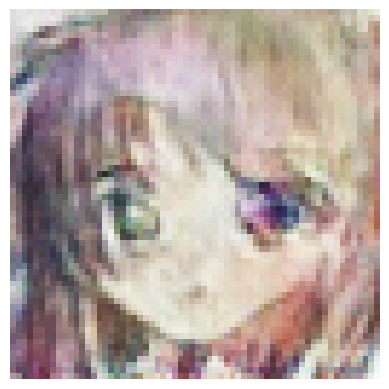

In [ ]:
generate_single_image(model_path, latent_size, device)
